In [560]:
# gerekli kütüphaneleri yüklüyoruz
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [561]:
# kredi kartının ilk numarasına türünü buluyoruz
FIRST_NUMBER_OF_CARD = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

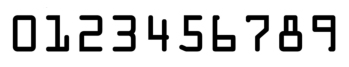

In [562]:
# referans ocr a görüntüsünü yükleyip-kart numaralarının yazıldığı yazı tipi-
# gri tonlamaya dönüştürdük sonra tersini alıyoruz ki arkası beyaz yazılar siyah görünsün
ref = cv2.imread("C:\\Users\Yaren\Desktop\ocr_a_reference.png")
plt.figure()
plt.axis("off")
plt.imshow(ref)

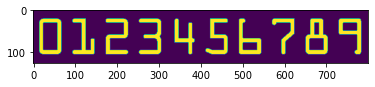

In [563]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

In [564]:
# rakamların ana hatlarını bulup soldan sağa sıralıyoruz
# rakam adını roi ile eşleştiriyoruz
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[1] if imutils.is_cv3() else refCnts[0]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [565]:
digits = {}

In [566]:
# ocr a referans konturları üzerinde döngü oluşturuyoruz
for (i, c) in enumerate(refCnts):
    # rakam için sınırlayıcı kutu hesaplayıp yeniden boyutlandırıyoruz
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:(y + h), x:(x + w)]
    roi2 = cv2.resize(roi, (57, 88))
 
    # digit sözlüğünü güncelleyip roi ile eşleştirdik
    digits[i] = roi

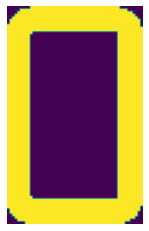

In [567]:
plt.figure()
plt.axis("off")
plt.imshow(digits[0])

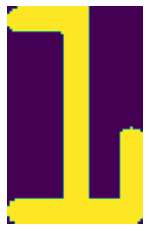

In [568]:
plt.figure()
plt.axis("off")
plt.imshow(digits[1])

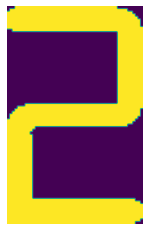

In [569]:
plt.figure()
plt.axis("off")
plt.imshow(digits[2])

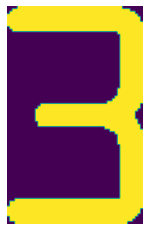

In [570]:
plt.figure()
plt.axis("off")
plt.imshow(digits[3])

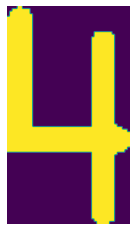

In [571]:
plt.figure()
plt.axis("off")
plt.imshow(digits[4])

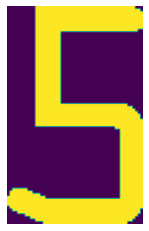

In [572]:
plt.figure()
plt.axis("off")
plt.imshow(digits[5])

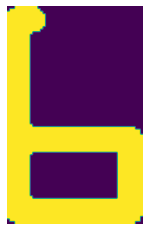

In [573]:
plt.figure()
plt.axis("off")
plt.imshow(digits[6])

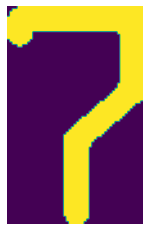

In [574]:
plt.figure()
plt.axis("off")
plt.imshow(digits[7])

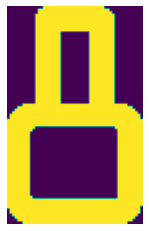

In [575]:
plt.figure()
plt.axis("off")
plt.imshow(digits[8])

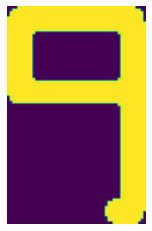

In [576]:
plt.figure()
plt.axis("off")
plt.imshow(digits[9])

In [577]:
# bir dikdörtgen veya kareyi yapılandırdık
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

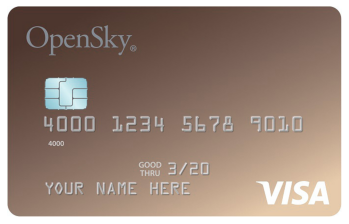

In [578]:
# giriş görüntüsünü yükleyip, yeniden boyutlandık ve gri tonlamaya dönüştürdük
image = cv2.imread("C:\\Users\Yaren\Desktop\kart_3.png")
plt.figure()
plt.axis("off")
plt.imshow(image)

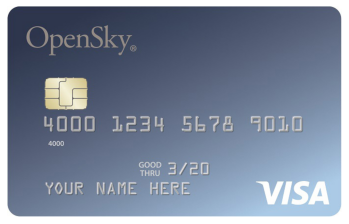

In [579]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.figure()
plt.axis("off")
plt.imshow(image)

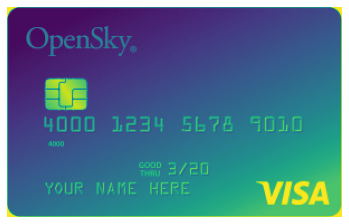

In [580]:
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray)

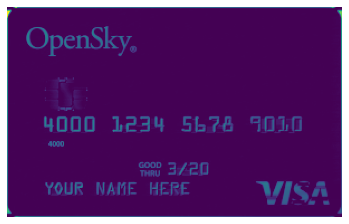

In [581]:
# koyu bir arka plana karşı açık bölgeleri bulmak için bir -white hat-
# morfolojik operatörü uyguladık - kredi kartı numaraları gibi- 
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.figure()
plt.axis("off")
plt.imshow(tophat)

In [582]:
# görüntüsünün Scharr gradyanını hesaplayıp
# ardından geri kalanını [0, 255] aralığına geri ölçekledik
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

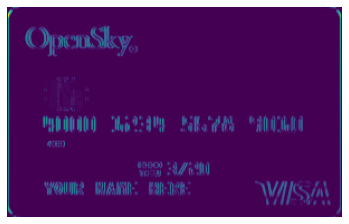

In [583]:
plt.figure()
plt.axis("off")
plt.imshow(gradX)

In [584]:
# numaraların arasındaki boşlukları kapatmak için kapatma işlemi uygulayıp
# görüntüyü ikiye ayırmak için Otsu'nun eşikleme yöntemini uyguladık
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [585]:
# yine kredi kartı numara bölgeleri arasındaki boşlukları kapatmaya yardımcı olmak için
# ikili görüntüye ikinci bir kapatma işlemi uyguladık
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

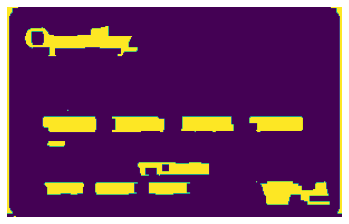

In [586]:
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [587]:
# konturleri bulup rakam konumlarının listesini başlattık 
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv3() else cnts[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [588]:
locs = []

In [589]:
# konturlar üzerinden döngü oluşturuyoruz
for (i, c) in enumerate(cnts):
    # konturun sınırlayıcı kutusunu hesaplayıp
    # en boy oranını elde etmek için sınırlayıcı kutu koordinatlarını kullandık
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
 
    # kartlarda 4 basamaklı 4 grupkullanıldığından
    # en boy oranına göre potansiyel konturları kısaltıyoruz
    if ar > 2.5 and ar < 4.5:
        # konturları minimum / maksimum genişlik ve yükseklikte kısalttık
        if (w > 40 and w < 70) and (h > 10 and h < 20):
            # kutu bölgesini konumlayıp listemize ekledik 
            locs.append((x, y, w, h))

In [590]:
# rakam konumlarını soldan sağa sıraladık 
# sonra sınıflandırılmış rakamların listesini başlattık 
locs = sorted(locs, key=lambda x:x[0])

In [591]:
locs

[(32, 98, 48, 14), (94, 98, 47, 14), (156, 98, 47, 14), (217, 98, 48, 14)]

In [592]:
output = []

In [593]:
# 4 basamaklı 4 grup üzerinden döngü
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # grup basamaklarının listesini başlattık
    groupOutput = []
 
    # gri tonlamalı görüntüden 4 basamaklı grup ROI'sini çıkarıp
    # rakamları kredi kartının arka planından bölümlere ayırmak için eşik uyguladık
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    # her bir grubun ana hatlarını tespit edip
    # rakam konturlarını soldan sağa sıraladık 
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    
    digitCnts = digitCnts[1] if imutils.is_cv3() else digitCnts[0]
    # digitCnts = digitCnts[0] if imutils.is_cv2() else digitCnts[1]
    digitCnts = contours.sort_contours(digitCnts,
    method="left-to-right")[0]

    # rakam konturları üzerinden döngü
    for c in digitCnts:
        # tek basamağın sınırlayıcı kutusunu hesaplayıp basamağı çıkarttık 
        # ocr a görüntüsüyle aynı boyut olacak şekilde yeniden boyutlandırdık 
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
 
        # şablon eşleştirme puanlarının bir listesini başlattık 
        scores = []
 
        # referans basamak adı ve basamak roi üzerinde döngü 
        for (digit, digitROI) in digits.items():
            # korelasyona dayalı şablon eşleştirmesi uygulayıp
            # puan listesini güncelledik
            result = cv2.matchTemplate(roi, digitROI,
                                       cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
 
        # basamaklı ROI için sınıflandırma, * en büyük * şablon eşleştirme puanına sahip referans basamak adı olacaktır 
        groupOutput.append(str(np.argmax(scores)))
        # grup etrafında rakam sınıflandırmalarını çizdik
        cv2.rectangle(image, (gX - 5, gY - 5),
                      (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
 
    # çıktı basamak listesini güncelledik
    output.extend(groupOutput)

In [594]:
# kredi kartı bilgilerini ekrana görüntülüyoruz
print("Credit Card Type: {}".format(FIRST_NUMBER_OF_CARD[output[0]]))

Credit Card Type: Visa


In [595]:
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 4000123456789010


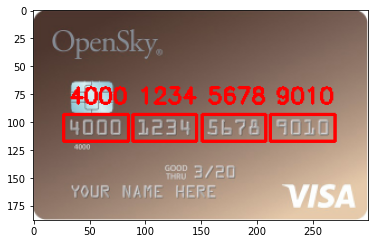

In [596]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))